## Overview The Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os
print(os.listdir("./archive"))

['.DS_Store', 'one-indexed-files-notrash_test.txt', 'zero-indexed-files.txt', 'one-indexed-files-notrash_val.txt', 'garbage_classification', 'one-indexed-files-notrash_train.txt', 'one-indexed-files.txt']


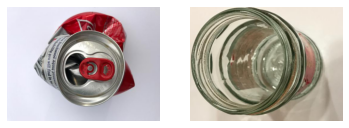

In [2]:
filepath = "./archive/garbage_classification/images/metal/metal100.jpg"
filepath2 = "./archive/garbage_classification/images/glass/glass21.jpg"

img1 = Image.open(filepath)
img2 = Image.open(filepath2)
img_size = 128
plt.subplot(1, 2, 1)
#img1 = img1.resize((img_size, img_size))
plt.imshow(img1)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.axis("off")
plt.show()

In [3]:
cardboard = "./archive/garbage_classification/images/cardboard/"
glass= "./archive/garbage_classification/images/glass/"
metal= "./archive/garbage_classification/images/metal/"
paper= "./archive/garbage_classification/images/paper/"
plastic=  "./archive/garbage_classification/images/plastic/"
trash=  "./archive/garbage_classification/images/trash/"

In [23]:
minh, minv = 100000,100000

for p in range(1,404):
    pic = Image.open(cardboard+"cardboard"+str(p)+".jpg")
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
for u in range(1,502):
    pic = Image.open(glass+"glass"+str(u)+".jpg")
    if pic.size[0] < minh:
        minh = pic.size[0]
    if pic.size[1] < minv:
        minv = pic.size[1]
print(minh)
print(minv)

512
384


In [45]:
train_cardboard = []
for p in range(1,404):
    image = Image.open(cardboard+"cardboard"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    image = image.convert(mode="L")
    train_cardboard.append(image)

train_glass = []
for p in range(1,502):
    image = Image.open(glass+"glass"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    image = image.convert(mode="L")
    train_glass.append(image)

train_metal = []
for p in range(1,411):
    image = Image.open(metal+"metal"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    image = image.convert(mode="L")
    train_metal.append(image)

train_paper = []
for p in range(1,595):
    image = Image.open(paper+"paper"+str(p)+".jpg")
    image = image.resize((img_size, img_size))
    image = image.convert(mode="L")
    train_paper.append(image)

In [46]:
X = np.empty((403+501+410+594, img_size * img_size))
index = 0
for pl in train_cardboard:
    X[index] = np.array(pl).reshape(img_size * img_size)
    index += 1
for ul in train_glass:
    X[index] = np.array(ul).reshape(img_size * img_size)
    index += 1    
p = np.ones(954)
u = np.zeros(954)
y = np.concatenate((p, u), axis=0).reshape(X.shape[0], 1)

print(X)
print("x shape: ", X.shape)
print("y shape: ", y.shape)

[[212. 211. 211. ...  94.  93.  94.]
 [221. 218. 214. ...  77.  73.  73.]
 [209. 207. 207. ...  63.  51.  73.]
 ...
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]
 [  0.   0.   0. ...   0.   0.   0.]]
x shape:  (1908, 4096)
y shape:  (1908, 1)


In [47]:
from sklearn.model_selection import train_test_split

# extract train sub-set
X_train, X_remain, y_train, y_remain = train_test_split(X, y, test_size=0.40, random_state=42)

# extract cross validation and test sub-sets
X_test, X_val, y_test, y_val = train_test_split(X_remain, y_remain, test_size=0.50, random_state=42)

print(f"X train flatten: {X_train.shape}")
print(f"y train: {y_train.shape}")

print(f"X val flatten: {X_val.shape}")
print(f"y val: {y_val.shape}")

print(f"X test flatten: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train flatten: (1144, 4096)
y train: (1144, 1)
X val flatten: (382, 4096)
y val: (382, 1)
X test flatten: (382, 4096)
y test: (382, 1)


## Logistic Regression

In [7]:
def sigmoid(z):
    """
    return the sigmoid of z
    """

    gz = 1/(1 + np.exp(-z))
    
    return gz

In [11]:
def featureNormalization(X):
    """
    Take in numpy array of X values and return normalize X values,
    the mean and standard deviation of each feature
    """
    mean= np.mean(X, axis=0)
    std= np.std(X, axis=0)
    
    X_norm =(X-mean)/std
    
    return X_norm , mean , std

In [8]:
def costFunctionReg(X, y, theta, Lambda):
    """
    Take in numpy array of  data X, labels y and theta, to return the regularized cost function and gradients
    of the logistic regression classifier
    """
    
    # number of training examples 
    m = X.shape[0]
        
    # vector of the model predictions for all training examples      
    h = sigmoid(np.dot(X, theta))
    
    error = (-y * np.log(h)) - ((1 - y)*np.log(1-h))
    
    # cost function without regularization term
    cost = sum(error)/m
    
    # add regularization term to the cost function
    regCost = cost + Lambda/(2*m) * sum(theta[1:]**2)
    
    # gradient of theta_0
    grad_0 = (1/m) * np.dot(X.transpose(),(h - y))[0]
    
    # vector of gradients of theta_j from j=1:n (adding the regularization term of the gradient)
    grad = (1/m) * np.dot(X.transpose(),(h - y))[1:] + (Lambda/m)* theta[1:]
       
    # all gradients in a column vector shape
    grad_all = np.append(grad_0,grad)
    grad_all = grad_all.reshape((len(grad_all), 1))
    
    return regCost[0], grad_all

In [16]:
def gradientDescent(X, y, theta, alpha, num_iters, Lambda):
    """
    Take in numpy array X, y and theta and update theta by taking num_iters gradient steps
    with learning rate of alpha
    Lambda is the regularization term
    return theta and the list of the cost of theta during each iteration
    """
    
    J_history =[]
    
    for i in range(num_iters):
        
        # call CostFunctionReg 
        cost, grad = costFunctionReg(X, y, theta, Lambda)

        # if i <2:
        #     tehta = theta
        #     print("cost: ", cost)
        #     print("grad: ", grad)
        #     print("theta: ", theta)
        
        # update theta
        theta = theta - (alpha * grad)
        
        J_history.append(cost)
    
    return theta , J_history

In [48]:

X_train, X_mean, X_std = featureNormalization(X_train)

# number of features
n = X_train.shape[1]

# Inicialize vector theta = 0
initial_theta = np.zeros((n,1))

#print(sigmoid(np.dot(X_train, initial_theta)))

# Optimization hyper-parameters 
alpha = 0.01 # learning rate
num_iters = 800
Lambda = 0.1

theta , J_history = gradientDescent(X_train, y_train, initial_theta, alpha, num_iters, Lambda)

# print(tehta)
# print("tehta: ", tehta)
# h = sigmoid(np.dot(X, tehta))
# print("sigmoid: ", h)
# error = (-y * np.log(h)) - ((1 - y)*np.log(1-h))
# print("error: ", error)

print(J_history)

[0.6931471805599269, 0.35826576810105754, 0.3422867047070703, 0.3263153852202206, 0.3103538851410758, 0.2944050938295273, 0.27847315451816507, 0.2625642134016368, 0.24668773423545998, 0.23085886500629196, 0.21510278108767011, 0.19946274358977498, 0.1840150444843376, 0.1688962058055909, 0.15434988517016512, 0.1407976370058104, 0.1289107465838537, 0.11957426300797554, 0.11351754483987905, 0.11060579655556901, 0.10966340994861998, 0.1094531194089678, 0.10940554657182162, 0.10938289485535177, 0.10936370680693806, 0.10934531936091205, 0.1093274160244824, 0.10930994491768335, 0.10929288374346707, 0.10927621424868181, 0.10925991943499494, 0.10924398321273734, 0.10922839032032033, 0.10921312627537445, 0.10919817733187989, 0.10918353044018404, 0.10916917320933178, 0.10915509387159164, 0.10914128124895199, 0.10912772472153288, 0.10911441419774479, 0.10910134008611347, 0.10908849326871868, 0.10907586507605153, 0.10906344726330451, 0.10905123198796313, 0.10903921178863747, 0.1090273795650326, 0.10

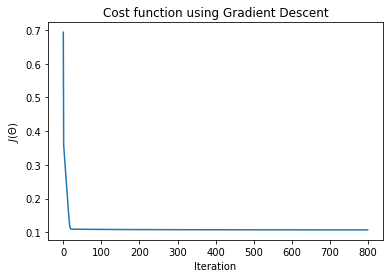

In [49]:
plt.plot(J_history)  # All classifiers
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.show()

## Accuracy

In [35]:
def classifierPredict(theta,X):
    """
    take in numpy array of theta and X and predict the class 
    """
    z = np.dot(X, theta)
    
    return z>0

In [50]:
def validationCurve(X, y, Xval, yval, learn_rate, num_iter, Lambda_array):
    """
    Returns the best lambda and the respective train and cross validation set errors
    """
    m = X.shape[0]  # Number of training examples 
    n = X.shape[1]  # number of features 
    mval = Xval.shape[0]  # Number of validation examples 
    
    error_train, error_val = [], []
    
    for lam in Lambda_array:
        print("Current Lambda: "+str(lam))

        theta_ini = np.zeros((n,1))
        theta, J_history = gradientDescent(X, y, theta_ini, learn_rate, num_iter, lam)

        h_train = classifierPredict(theta, X)
        h_val = classifierPredict(theta, Xval)

        error_train_i = (sum(y != h_train)/y.shape[0])[0]
        error_val_i = (sum(yval != h_val)/yval.shape[0])[0]

        print(error_train_i)
        print(error_val_i)

        error_train.append(error_train_i)
        error_val.append(error_val_i)
    
    ind = np.argmin(error_val)
    best_lambda = Lambda_array[ind]
        
    return best_lambda, error_train, error_val

Current Lambda: 0.01
0.022727272727272728
0.028795811518324606
Current Lambda: 0.1
0.022727272727272728
0.028795811518324606
Current Lambda: 0.3
0.022727272727272728
0.028795811518324606
Current Lambda: 1
0.022727272727272728
0.028795811518324606
Current Lambda: 3
0.022727272727272728
0.028795811518324606
Current Lambda: 10
0.022727272727272728
0.028795811518324606
Current Lambda: 30
0.022727272727272728
0.028795811518324606
Current Lambda: 35
0.022727272727272728
0.028795811518324606
Current Lambda: 40
0.022727272727272728
0.028795811518324606
Current Lambda: 45
0.022727272727272728
0.028795811518324606
Best Lambda: 0.01


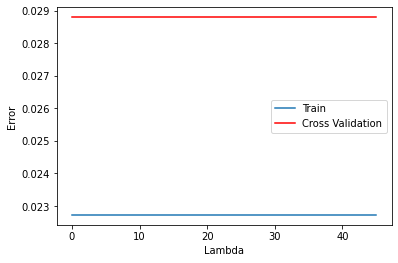

In [51]:
Lambda_array = [0.01, 0.1, 0.3, 1, 3, 10, 30, 35, 40, 45]

best_lambda, error_train, error_val = validationCurve(X_train, y_train, X_val, y_val, alpha, num_iters, Lambda_array)

print(f"Best Lambda: {best_lambda}")

plt.plot(Lambda_array,error_train,label="Train")
plt.plot(Lambda_array,error_val,label="Cross Validation", color="r")
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.legend()
plt.show()

(1526, 4096)
(1526, 1)


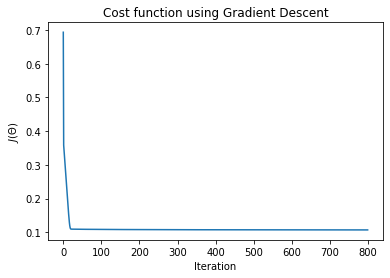

Etrain: 0.025557011795543906
Etest: 0.034031413612565446

Train Accuracy: 97.44429882044561 %
Test Accuracy: 96.59685863874346 %


In [52]:
X_train_2 = np.concatenate((X_train, X_test), axis=0)
print(X_train_2.shape)

y_train_2 = np.concatenate((y_train, y_test), axis=0)
print(y_train_2.shape)

m, n = X_train.shape
mval = X_val.shape[0]
mtest = X_test.shape[0]

theta_ini = np.zeros((n,1))
theta_optimized, J_history = gradientDescent(X_train, y_train, theta_ini, alpha, num_iters, best_lambda)

plt.plot(J_history)
plt.xlabel("Iteration")
plt.ylabel("$J(\Theta)$")
plt.title("Cost function using Gradient Descent")
plt.show()

pred_train = classifierPredict(theta_optimized, X_train_2)
Etrain = (sum(y_train_2 != pred_train)/y_train_2.shape[0])[0]

pred_test = classifierPredict(theta_optimized, X_test)
Etest = (sum(y_test != pred_test)/y_test.shape[0])[0]

print(f"Etrain: {Etrain}")
print(f"Etest: {Etest}\n")

print("Train Accuracy:", (1-Etrain)*100,"%")
print("Test Accuracy:", (1-Etest)*100,"%")